# Autoencoders


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from models import ConvEncoder, ConvDecoder, ConvAE
from training import train_epoch, val_epoch, train_epochs, ft_train_epoch, ft_val_epoch, ft_train_epochs
from functions import my_accuracy

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


## Dataset and Dataloader

In [2]:
### Dataset

dataset = datasets.MNIST('MNIST', train = True, download = True,
                             transform = transforms.Compose([
                               transforms.ToTensor(),
                                 transforms.Normalize(0.0,1.0)
                             ]))

test_data = datasets.MNIST('MNIST', train = False, download = True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                                 transforms.Normalize(0.0,1.0)
                             ]))

# Divide data dataset in train dataset and val dataset

train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000])

In [3]:
### Dataloaders
batch_size = 128

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle=True, num_workers=0)



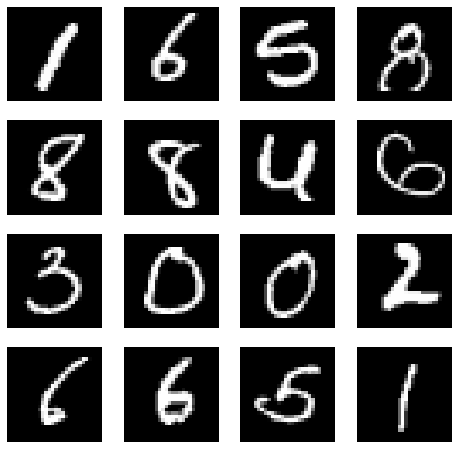

In [4]:
# Plot Mnist
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(1,cols * rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Training

In [5]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


### Adam

In [6]:
### Filename of the net
filename = 'AE_params.torch'

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
parameters = {
    "encoded_space_dim" : 20,
    "act" : nn.ReLU,
    "drop_p" : 0.1
}
net = ConvAE(parameters)

### Move to device
net.to(device)

ConvAE(
  (encoder): ConvEncoder(
    (first_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (second_conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_lin): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): 

  0%|          | 0/20 [00:00<?, ?it/s]

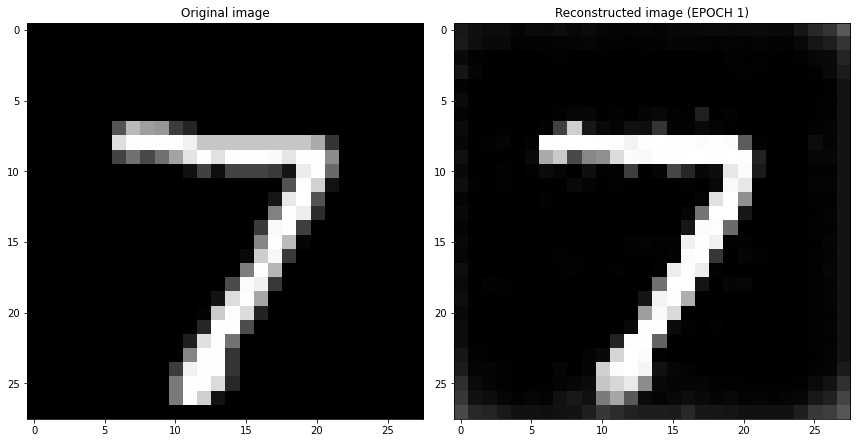

KeyboardInterrupt: 

In [7]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.0)

# Training 
max_num_epochs = 20
early_stopping = True
train_loss_sgd, val_loss_sgd = train_epochs(net, device, train_dataloader, val_dataloader, test_data, loss_function, optimizer, max_num_epochs, early_stopping)


In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_sgd, label='Train loss')
plt.semilogy(val_loss_sgd, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Save and load model

In [ ]:
### Save network parameters
### Save the network state
# Save network parameters

torch.save(net.state_dict(), filename)

In [ ]:
### Reload the network state
# Load network parameters
params_dict = torch.load(filename)
net.load_state_dict(params_dict)


## Network analysis

In [ ]:
### Get the encoded representation of the test samples
labels = []
matrix = []
for sample in tqdm_notebook(test_data):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    net.eval()
    with torch.no_grad():
        encoded_img, _  = net(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    matrix.append(encoded_img)
    labels.append(label)

matrix = np.array(matrix)



### PCA

In [ ]:
# Singular values decomposition
pca = PCA(n_components=2, svd_solver='full').fit_transform(matrix)

# Create dictionary
encoded_samples_pca = []
for i in tqdm_notebook(range(pca.shape[0])):
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(pca[i])}
    encoded_sample["label"] = labels[i]
    encoded_samples_pca.append(encoded_sample)


### t-SNE

In [ ]:
# t-SNE projection
tsne = TSNE(n_components=2, init='pca').fit_transform(matrix)

# Create dictionary
encoded_samples_tsne = []
for i in tqdm_notebook(range(tsne.shape[0])):
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(tsne[i])}
    encoded_sample["label"] = labels[i]
    encoded_samples_tsne.append(encoded_sample)

### Visualization

In [ ]:
# Convert to a dataframe
df_pca = pd.DataFrame(encoded_samples_pca)
df_tsne = pd.DataFrame(encoded_samples_tsne)

px.scatter(df_pca, x='Enc. Variable 0', y='Enc. Variable 1', color=df_pca.label.astype(str), opacity=0.7)
#px.scatter(df_tsne, x='Enc. Variable 0', y='Enc. Variable 1', color=df_tsne.label.astype(str), opacity=0.7)


In [ ]:
# Reconstruct images
fig, axs = plt.subplots(3, 2, figsize=(18,9))
net.eval()

# Get the output of a specific image (the test image at index 0 in this case)
img_indx =10
img = test_data[img_indx][0].unsqueeze(0).to(device)
label = test_data[img_indx][1]

with torch.no_grad():
    _ , rec_img  = net(img)
    
# Plot the reconstructed image
axs[0,0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,0].set_title('Original image: label %d' %label)
axs[0,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,1].set_title('Reconstructed image')



# Get the output of a specific image (the test image at index 0 in this case)
img_indx = 12
img = test_data[img_indx][0].unsqueeze(0).to(device)
label = test_data[img_indx][1]

with torch.no_grad():
    _, rec_img  =net(img)
    
# Plot the reconstructed image
axs[1,0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1,0].set_title('Original image: label %d' %label)
axs[1,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1,1].set_title('Reconstructed image')


# Get the output of a specific image (the test image at index 0 in this case)
img_indx = 122
img = test_data[img_indx][0].unsqueeze(0).to(device)
label = test_data[img_indx][1]

with torch.no_grad():
    _, rec_img  = net(img)
    
# Plot the reconstructed image
axs[2,0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2,0].set_title('Original image: label %d' %label)
axs[2,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2,1].set_title('Reconstructed image')



plt.tight_layout()



In [ ]:
### Generate samples from encoded space

# Generate a custom sample
custom_encoded_sample = np.random.rand(20)
encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

# Decode sample
decoder.eval()
with torch.no_grad():
    _, generated_img  = net.(encoded_value)

plt.figure(figsize=(12,10))
plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
plt.show()

In [ ]:
### Generate regular samples from encoded space

figure = plt.figure(figsize=(16, 16))
cols, rows = 8, 8

dim1 = np.linspace(-2,2,cols)
dim2 = np.linspace(-2,2,rows)

for i in range(cols):
    for j in range(rows):
        # Create  an encoded sample
        encoded_sample = [dim1[i], dim2[j]]
        encoded_sample = torch.tensor(encoded_sample).float().unsqueeze(0).to(device)
        
        # Decode sample
        decoder.eval()
        with torch.no_grad():
            generated_img  = decoder(encoded_sample)
        sample_idx = torch.randint(len(train_data), size=(1,)).item()
        img, label = train_data[sample_idx]
        figure.add_subplot(rows, cols, j*cols+1+i)
        plt.axis("off")
        plt.imshow(generated_img.squeeze().cpu().numpy(), cmap="gray")
plt.show()

# Fine tuning

In [ ]:
print(net)

In [ ]:
# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in net.named_parameters():
    print(param_name)
    print('\tFreezing update')
    param.requires_grad = False

In [ ]:
# Change the last layer to match the new reduced problem    
num_classes = 10
net.encoder.encoder_lin[2] = torch.nn.Linear(128, num_classes)
print(net)

In [ ]:
# Allow the training of the last two layers (classifier[4] and classifier[6])
for param in net.encoder.encoder_lin[0].parameters():
    param.requires_grad = True 
for param in net.encoder.encoder_lin[2].parameters():
    param.requires_grad = True 

# Check if correct
for param_name, param in net.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

## Training

In [ ]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizers
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.0)

### Training epochs
max_num_epochs = 20
early_stopping = True
train_loss_log, val_loss_log, accuracy = ft_train_epochs(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping)


In [ ]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_log, label='Train loss')
ax1.semilogy(val_loss_log, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(accuracy, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

# Denoising Autoencoder

In [ ]:
### Define the noising function

class AddNoise(object):
    """
    Add Gaussian noise with given standard deviation to Mnist images
    """
    def __init__(self, std = 1.):
        self.std = std
        
    def __call__(self, img):
        return img+torch.randn_like(img)*self.std
        

In [ ]:
### Define noise function
noise = AddNoise(std = 1.)

In [ ]:
### Plot image and noised version

img_indx = 12
img = test_data[img_indx][0]

noised_img = noise(img)


# Plot the reconstructed image
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].imshow(img.squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Original image')
axs[1].imshow(noised_img.squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Noised image')
plt.tight_layout()

## Define the Network

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 20
net = ConvAE(encoded_space_dim=encoded_space_dim)

### Move to device
net.to(device)

## Training

In [ ]:
# Define the loss function
loss_function = nn.MSELoss()

# Define the optimizers
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.0)

### Training loop with progress bar
num_epochs = 20


train_loss_log = []
val_loss_log = []

pbar = tqdm_notebook(range(num_epochs))

for epoch_num in pbar:
    
    # Train an epoch and save losses
    train_epoch_loss = train_epoch(net, device, train_dataloader, loss_function, optimizer_1, noise = noise)
    # Validate an epoch
    val_epoch_loss = val_epoch(net,  device, val_dataloader, loss_function, noise = noise)
    # Compute averages over an epoch
    mean_train_loss = np.mean(train_epoch_loss)
    mean_val_loss = np.mean(val_epoch_loss)
    # Append to plot
    train_loss_log.append(mean_train_loss)
    val_loss_log.append(mean_val_loss)
    pbar.set_description("Train loss: %s" %round(mean_train_loss,3)+","+"Validation loss %s" %round(mean_val_loss,3))
    
    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_data[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        _, rec_img  = net(img)
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(noise(img).cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original noised image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('denoising_autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('denoising_autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch_num + 1))
    plt.show()
    plt.close()
    
    sleep(0.03)
    pbar.update()

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Save and load the model

In [ ]:
### Save network parameters
### Save the network state
# Save network parameters
filename = 'DenoisingAE_params.torch'

torch.save(net.state_dict(), filename)

In [ ]:
### Reload the network state
# Load network parameters
params_dict = torch.load(filename)

net.load_state_dict(params_dict)

## Network analysis

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_data):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(noise(img))
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

In [ ]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

# Scatter plot
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
# Reconstruct images
# Get the output of a specific image (the test image at index 0 in this case)
img_indx =10
img = test_data[img_indx][0].unsqueeze(0).to(device)
label = test_data[img_indx][1]
encoder.eval()
decoder.eval()
with torch.no_grad():
    rec_img  = decoder(encoder(noise(img)))
    
# Plot the reconstructed image
fig, axs = plt.subplots(3, 2, figsize=(18,9))
axs[0,0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,0].set_title('Original image: label %d' %label)
axs[0,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,1].set_title('Reconstructed image')
plt.tight_layout()
